# Getting Started with Sionna

In [1]:
#conda create -n sionna_win python=3.10
#conda activate sionna_win


In [5]:
import sionna as sn

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse
import tensorflow as tf

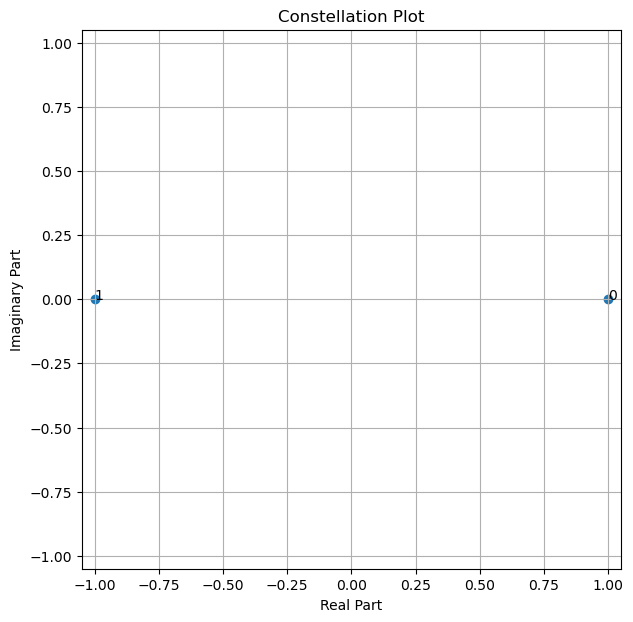

In [6]:
NUM_BITS_PER_SYMBOL = 1 # BPSK
constellation = sn.mapping.Constellation("pam", NUM_BITS_PER_SYMBOL, normalize = True)
constellation.show();

In [7]:
# The mapper uses the same constellation object as the demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [8]:
binary_source = sn.utils.BinarySource()

In [9]:
no = sn.utils.ebnodb2no(ebno_db=10.0,num_bits_per_symbol=NUM_BITS_PER_SYMBOL,coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
awgn_channel = sn.channel.AWGN()

In [10]:
BATCH_SIZE = 1 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,1024]) # Blocklength
print("Shape of bits: ", bits.shape)

x = mapper(bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

Shape of bits:  (1, 1024)
Shape of x:  (1, 1024)
Shape of y:  (1, 1024)
Shape of llr:  (1, 1024)


In [13]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [0. 0. 0. 0. 1. 1. 0. 0.]
First 8 transmitted symbols: [ 1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j]
First 8 received symbols: [ 1.11+0.37j  0.99-0.29j  0.94+0.05j  1.15-0.35j -1.33-0.24j -0.92-0.07j
  1.1 +0.09j  0.81+0.06j]
First 8 demapped llrs: [-44.45 -39.77 -37.6  -45.96  53.    36.91 -43.92 -32.58]


# Keras API to perform Uncoded AWGN BPSK transmission

In [10]:
class UncodedBPSKSystemAWGN(tf.keras.Model):
    def __init__(self, block_length):
        """
        Uncoded BPSK transmission over AWGN channel model.

        Parameters
        ----------
        block_length: int
            Number of bits per transmitted block

        Input
        -----
        batch_size: int
            Batch size for Monte-Carlo simulation
        ebno_db: float
            Eb/No value in dB

        Output
        ------
        (bits, llr): tuple
            Tuple containing transmitted bits and received LLRs
        """
        super().__init__()
        
        # Force BPSK configuration
        self.num_bits_per_symbol = 1  # Fixed for BPSK
        self.block_length = block_length
        
        # BPSK constellation setup
        self.constellation = sn.mapping.Constellation(
            constellation_type="pam",
            num_bits_per_symbol=self.num_bits_per_symbol,
            normalize=True  # Normalize to unit energy
        )
        
        # System components
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    def call(self, batch_size, ebno_db):
        # Convert Eb/No to noise variance
        no = sn.utils.ebnodb2no(
            ebno_db,
            num_bits_per_symbol=self.num_bits_per_symbol,
            coderate=1.0  # Uncoded
        )

        # Generate random bits [batch_size, block_length]
        bits = self.binary_source([batch_size, self.block_length])
        
        # Map to BPSK symbols (0->+1, 1->-1)
        x = self.mapper(bits)
        
        # Add AWGN noise
        y = self.awgn_channel([x, no])
        
        # Compute LLRs (log-likelihood ratios)
        llr = self.demapper([y, no])
        
        return bits, llr


In [11]:
model_uncoded_awgn = UncodedBPSKSystemAWGN(block_length=1024)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5837e-01 | 1.0000e+00 |    32434502 |   204800000 |       200000 |      200000 |        23.0 |reached max iter       
   -2.421 | 1.4228e-01 | 1.0000e+00 |    29138733 |   204800000 |       200000 |      200000 |        25.1 |reached max iter       
   -1.842 | 1.2629e-01 | 1.0000e+00 |    25864756 |   204800000 |       200000 |      200000 |        24.0 |reached max iter       
   -1.263 | 1.1072e-01 | 1.0000e+00 |    22675226 |   204800000 |       200000 |      200000 |        23.0 |reached max iter       
   -0.684 | 9.5598e-02 | 1.0000e+00 |    19578391 |   204800000 |       200000 |      200000 |        38.6 |reached max iter       
   -0.105 | 8.1206e-02 | 1.0000e+00 |    16631066 |   204800000 |       200000 |     

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.15837159, 0.14227897, 0.12629275, 0.11071888, 0.09559761,
        0.08120638, 0.0676543 , 0.05520583, 0.04394048, 0.0340654 ,
        0.02559532, 0.01857057, 0.01294912, 0.00862729, 0.00545585,
        0.00325684, 0.0018148 , 0.00094237, 0.00044544, 0.00018881])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 0.999865, 0.996065, 0.964855, 0.845565, 0.617915,
        0.36602 , 0.175425])>)

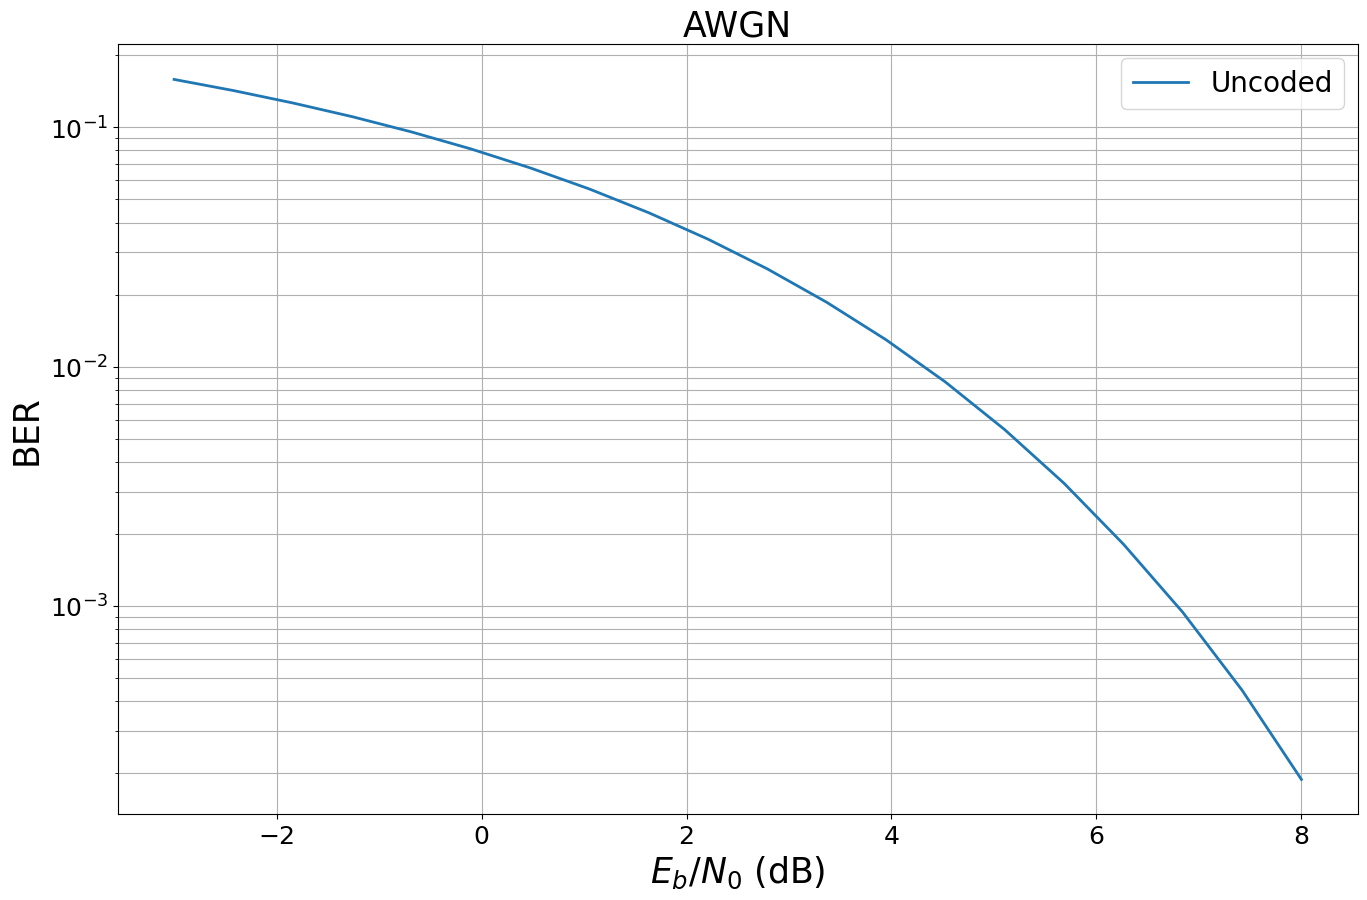

In [12]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 8.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  legend="Uncoded", 
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True)

# LDPC with BPSK on AWGN channel

In [12]:
class CodedBPSKSystemAWGN(tf.keras.Model): # Inherits from Keras Model
    def __init__(self, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("pam", 1)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

In [13]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedBPSKSystemAWGN(n=2048,coderate=CODERATE)

In [ ]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedBPSKSystemAWGN(n=2048,coderate=CODERATE)
ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
                   batch_size=BATCH_SIZE,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

In [17]:
@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions   
    return model_coded_awgn(batch_size, ebno_db)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.7956e-01 | 1.0000e+00 |    11450602 |    40960000 |        40000 |       40000 |       116.4 |reached max iter       
     -2.0 | 2.5083e-01 | 1.0000e+00 |    10274114 |    40960000 |        40000 |       40000 |       123.9 |reached max iter       
     -1.0 | 2.1566e-01 | 1.0000e+00 |     8833522 |    40960000 |        40000 |       40000 |       358.8 |reached max iter       
      0.0 | 1.6089e-01 | 1.0000e+00 |     6589999 |    40960000 |        40000 |       40000 |       125.1 |reached max iter       
      1.0 | 2.0458e-02 | 4.6860e-01 |      837956 |    40960000 |        18744 |       40000 |       135.7 |reached max iter       
      2.0 | 5.1270e-07 | 7.5000e-05 |          21 |    40960000 |            3 |     

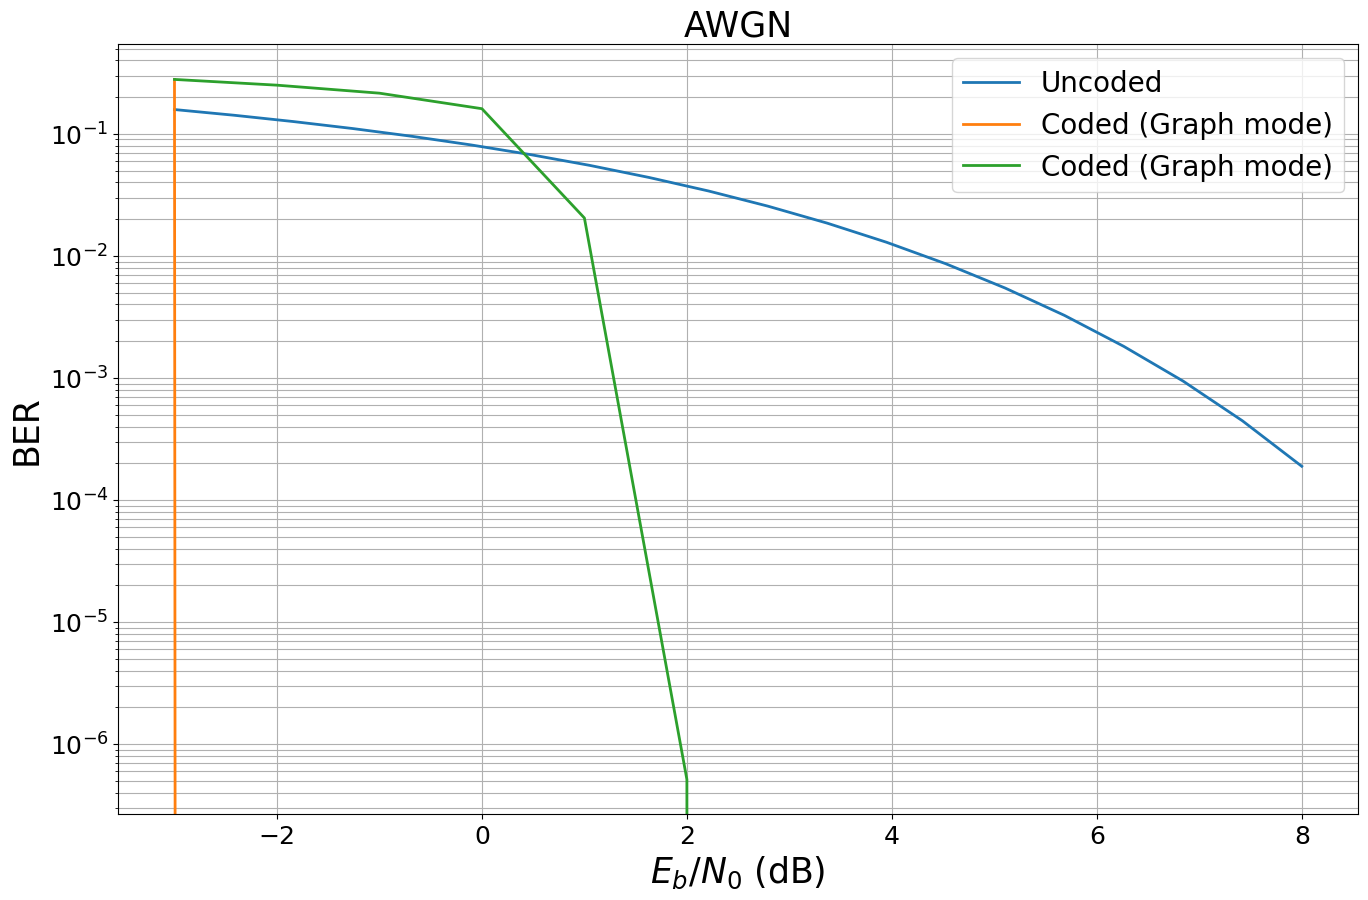

In [19]:
ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=20,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

# Recreating the AR uncoded results

In [14]:
# Parameters
#The number of channel samples we estimate into the future 
packet_size = 50
#The number of pilot samples we transmit incase of retransmission
pilot_size = 50
#Order of our VAR model
var_order = 25
#MSE threshold to decide if a retransmission is required incase of VAR-based estimation
mse_threshold = 0.1
#SNR in dB
ebno_db = 10 
#Minimum number of samples needed for VAR fitting + buffer
initial_pilots = var_order + 2  

In [19]:
def generate_random_bits(n):
    """
    Generate random bits as either -1 or 1.

    Args:
        n (int): Number of bits to generate.

    Returns:
        np.ndarray: Array of random bits (-1 or 1) of size n.
    """
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)


def transmit_data(data, channel, ebno_db, coderate = 0.5):
    """
    Simulate data transmission over a wireless channel with noise.

    Args:
        data (np.ndarray): Input data to be transmitted.
        channel (complex or float): Channel gain.
        ebno_db (float): Signal-to-noise ratio in decibels (dB). 

    Returns:
        np.ndarray: Noisy received signal.
    """
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(ebno_db / 10) * coderate )
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise


def estimate_channel(received, data):
    """
    Estimate the channel coefficient using least squares.

    Args:
        received (np.ndarray): Received signal.
        data (np.ndarray): Transmitted data.

    Returns:
        complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
    """
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h


def collect_pilot_estimates(current_index, num_pilots, channel_vals, ebno_db, pilot_size=50):
    # List to store channel estimates.
    estimates = []
    # Collect channel estimates for the specified number of pilots.
    for _ in range(num_pilots):
        # Check if the remaining channel values are sufficient for a pilot.
        if current_index + pilot_size > len(channel_vals):
            break

        # Generate pilot bits for transmission.
        pilot_bits = generate_random_bits(pilot_size)
        # Extract the actual channel values for the current pilot.
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        # Simulate the transmission and reception of pilot data.
        received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db)
        # Estimate the channel from the received pilot data.
        hbar = estimate_channel(received_pilot, pilot_bits)
        # Store the estimated channel coefficient.
        estimates.append(hbar)
        # Move the index forward by the size of the pilot.
        current_index += pilot_size

    return estimates, current_index


def predict_channel_var(channel_history, var_order = 25, steps=1):
    """
    Predict the future channel value using a Vector AutoRegressive (VAR) model.

    Args:
        channel_history (np.ndarray): Historical channel values as a 1D array of complex numbers.
        steps (int): Number of future steps to predict. Default is 1.

    Returns:
        complex: Predicted channel value as a complex number.

    Raises:
        ValueError: If the length of `channel_history` is less than or equal to the VAR model order.
    """
    # Ensure there are enough samples for the VAR model.
    if len(channel_history) <= var_order:
        raise ValueError(f"Not enough samples for VAR. Need >{var_order}, got {len(channel_history)}")
    # Separate real and imaginary parts of the channel history for the VAR model.
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    # Create and fit the VAR model using the specified order.
    model = VAR(channel_history_separated)
    results = model.fit(var_order)
    # Forecast future values based on the fitted model and past data.
    forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
    # Combine the real and imaginary parts to return the predicted complex channel value.
    return forecast[0, 0] + 1j * forecast[0, 1]



def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    """
    Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

    Args:
        Fd (float): Maximum Doppler frequency (Hz).
        Fs (float): Sampling frequency (Hz).
        N (int): Number of samples to generate.

    Returns:
        np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
    """
    def jakes_sos(P, K, Fs, Fd, N, typ):
        """
        Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

        Args:
            P (int): Number of time points.
            K (int): Number of independent processes.
            Fs (float): Sampling frequency (Hz).
            Fd (float): Maximum Doppler frequency (Hz).
            N (int): Number of sinusoids used in the model.
            typ (str): Type of signal to generate ('comp' for complex, others for real).

        Returns:
            np.ndarray: Jakes random variables (complex values).
        """
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0

        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Set the center frequency
    Fc = 1000000000
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs

    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')

    # Return the generated Jakes random variables
    return correlated_jakes_rvs


In [16]:
Fd = 1000
Fs = 100000
N = 100000
# Generate and save channels for the given Doppler frequency.
generate_channels_for_doppler_frequencies(Fd, Fs, N)

# Load the complex channel values from the file.
with open("channels.txt", "r") as f:
    channel_vals = [json.loads(line)[0] for line in f]
channel_vals = np.array([complex(re, im) for re, im in channel_vals])

In [71]:
def autoreg_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    """
    Autoregressive Simulation for channel prediction.
    
    Args:
        Fd (float): Doppler frequency.
        Fs (float): Sampling frequency.
        channel_vals (np.ndarray): Array of actual channel values.
        mse_threshold (float): Threshold for MSE to determine retraining.
        N (int): Total number of samples to simulate.
        SNR (float): Signal-to-noise ratio in dB (interpreted as Eb/N0).
        packet_size (int): Size of each data packet in bits (default: 50).
        pilot_size (int): Size of pilot transmissions in bits (default: 50).
        var_order (int): Order of the VAR model (default: 25).
        initial_pilots (int): Number of initial pilot transmissions (default: 50).
    
    Returns:
        tuple:
            - retrans_frequency (float): Pilot-to-data ratio (frequency of retransmission).
            - ber (float): Bit error rate.
    """
    # Initialize Sionna components
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)
    
    # For uncoded transmission, coderate=1.0
    coderate = 1.0
    
    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0

    # Initial pilots (keep original logic)
    initial_estimates, current_index = collect_pilot_estimates(
        current_index=current_index, 
        num_pilots=initial_pilots, 
        channel_vals=channel_vals, 
        ebno_db = ebno_db,
        pilot_size=pilot_size
    )
    channel_estimates.extend(initial_estimates)
    pilot_requests.extend(range(0, current_index, pilot_size))
    total_bits += initial_pilots * pilot_size

    # Main loop - keep Python while loop
    while current_index < len(channel_vals) - packet_size:
        # VAR prediction (keep original numpy-based version)
        try:
            htilde = predict_channel_var(
                channel_history=channel_estimates,
                var_order=var_order
            )
        except ValueError:
            break

        # Generate bits with batch dimension [1, packet_size]
        data_bits = binary_source([1, packet_size])  # Tensor shape (1, 50)
        x = mapper(data_bits)                       # Tensor shape (1, 50)
        x = tf.squeeze(x).numpy()                   # Remove batch dim -> (50,)
        total_bits_ber += packet_size
        # Extract actual channel values for current packet
        actual_channel = channel_vals[current_index:current_index + packet_size]
        # Convert Eb/N0 to noise variance (for uncoded transmission, coderate=1.0)
        # no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=coderate)
        # Use the updated transmit_data function with noise variance
        y = transmit_data(x, actual_channel, ebno_db, coderate = 1)
        # Original demodulation logic
        dbar = np.sign(np.real(y * np.conjugate(htilde) / (np.abs(htilde)**2)))
        # Re-estimate the channel using the demodulated data.
        hnought = estimate_channel(y, dbar)        
        # Compute the mean squared error between predicted and re-estimated channels.
        mse = np.abs(htilde - hnought)**2

        # Check if the error exceeds the threshold.
        if mse > mse_threshold:
            # Collect new pilot estimates if error is too high.
            new_estimates, current_index = collect_pilot_estimates(
                current_index=current_index, 
                num_pilots=initial_pilots, 
                channel_vals=channel_vals, 
                ebno_db = ebno_db,
                pilot_size=pilot_size
            )
            channel_estimates.extend(new_estimates)
            pilot_requests.extend(range(current_index - len(new_estimates) * pilot_size, current_index, pilot_size))
            total_bits += len(new_estimates) * pilot_size
        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            current_index += packet_size
            total_bits += packet_size

            # Original bit comparison
            data_bits_np = data_bits.numpy().flatten()  # Convert to 1D numpy array
            for i in range(len(data_bits_np)):
                if data_bits_np[i] != dbar[i]:
                    wrong_bits += 1

            # Stop if approaching the end of the simulation window.
            if current_index >= N - packet_size:
                break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(1 / (total_bits / (len(pilot_requests) * pilot_size)))
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits) if total_bits_ber > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber


In [80]:
#Testing out the simulation for specific Fd, N and Fs values
Fs = 100000
Fd = 1000
mse_threshold = 0.1
N = 100000
ebno_db = 10
packet_size = 50
pilot_size = 50
var_order = 25
initial_pilots = 27
retrans_frequency, ber = autoreg_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size, pilot_size, var_order, initial_pilots)
print(retrans_frequency)
print(ber)

0.989
0.00884


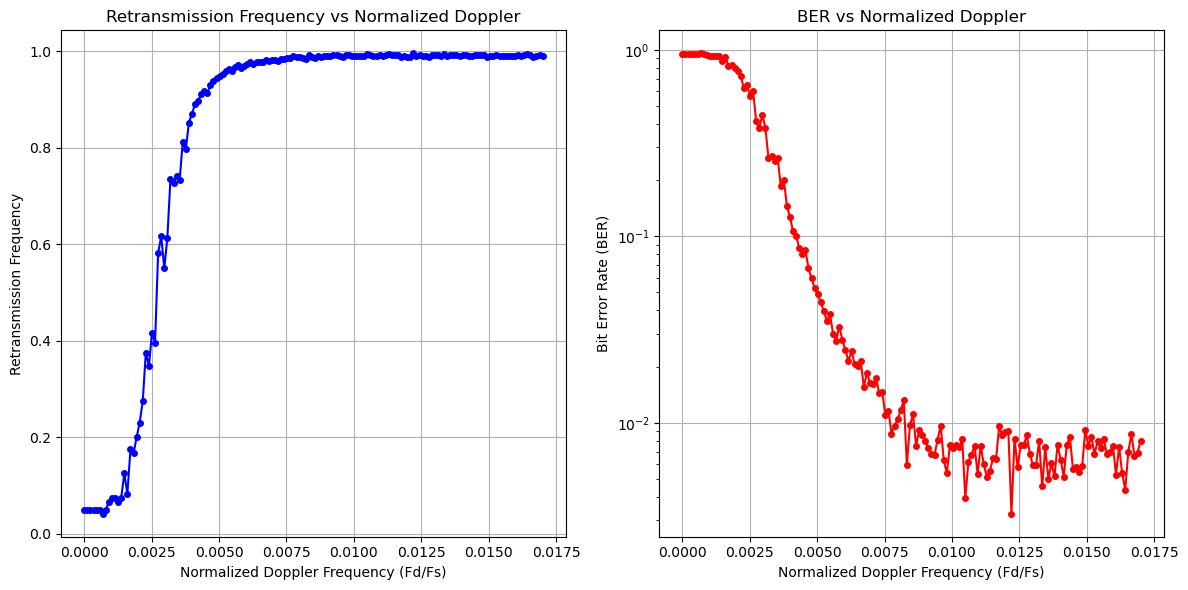

In [27]:
# Specifying certain parameters
# Number of pilots we transmit in a single retransmission
pilot_size = 50
# Number of packets that we predict channels for into the future incase of autoregressive or sequence modelling
packet_size = 50
# Order of the VAR we are using 
var_order = 25 
# Number of channel samples or total (pilot + packet) samples
N = 100000
# MSE threshold to decide when resampling is to be done
mse_threshold = 0.1
# SNR of the channel to determine the level of noise in the received signal
ebno_db = 10 
# Sampling frequency of the simulation
Fs = 100000 
# Number of initial pilots for VAR training
initial_pilots = 50

# Range of doppler frequencies to be explored in the plot - a total of 150 doppler frequencies
doppler_frequencies = np.linspace(0, 1700, 150)  
# Vectors to store the retransmission frequency and BER for plotting
retrans_frequencies = []
ber_values = []

# The simulation is performed 3 times to ensure averaging and smoothness of the curve
for Fd in doppler_frequencies:
    # Generate channels for current Doppler frequency
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        # Call autoreg_simulate with all required parameters
        retrans_frequency1, ber1 = autoreg_simulate(
            Fd=Fd,
            Fs=Fs,
            channel_vals=channel_vals,
            mse_threshold=mse_threshold,
            N=N,
            ebno_db = ebno_db,
            packet_size=packet_size,
            pilot_size=pilot_size,
            var_order=var_order,
            initial_pilots=initial_pilots
        )
        retrans_frequency += retrans_frequency1
        ber += ber1 
    
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

# Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(doppler_frequencies/Fs, retrans_frequencies, 'b-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler')
plt.grid(True)

# Plot BER vs normalized Doppler frequency
plt.subplot(1, 2, 2)
plt.semilogy(doppler_frequencies/Fs, ber_values, 'r-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Normalized Doppler')
plt.grid(True)

plt.tight_layout()
plt.show()

# AR with LDPC algorithm

In [81]:
def autoreg_ldpc_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    """
    LDPC-enhanced Autoregressive Simulation for channel prediction.
    
    This function follows the original autoreg_simulate approach but adds LDPC
    encoding and decoding to improve error performance.
    
    Args:
        Fd (float): Doppler frequency.
        Fs (float): Sampling frequency.
        channel_vals (np.ndarray): Array of actual channel values.
        mse_threshold (float): Threshold for MSE to determine retraining.
        N (int): Total number of samples to simulate.
        SNR (float): Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system).
        packet_size (int): Size of each data packet in bits (default: 50).
        pilot_size (int): Size of pilot transmissions in bits (default: 50).
        var_order (int): Order of the VAR model (default: 25).
        initial_pilots (int): Number of initial pilot transmissions (default: 50).
    
    Returns:
        tuple:
            - retrans_frequency (float): Pilot-to-data ratio (frequency of retransmission).
            - ber (float): Bit error rate.
    """
    # Define code rate (rate 0.5 means k bits -> 2k bits)
    coderate = 0.5
    
    # Initialize Sionna components
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)
    
    # Initialize LDPC encoder and decoder with rate 0.5 (k bits -> 2k bits)
    # For 50 input bits, we'll get 100 coded bits
    ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*packet_size)
    ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, 
                                            num_iter=20,  # Number of BP iterations 
                                            hard_out=True,  # Output hard bits (0/1) instead of LLRs
                                            return_infobits=True)  # Return only the information bits
    
    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0

    # Initial pilots (keep original logic)
    initial_estimates, current_index = collect_pilot_estimates(
        current_index=current_index, 
        num_pilots=initial_pilots, 
        channel_vals=channel_vals, 
        ebno_db = ebno_db,
        pilot_size=pilot_size
    )
    channel_estimates.extend(initial_estimates)
    pilot_requests.extend(range(0, current_index, pilot_size))
    total_bits += initial_pilots * pilot_size

    # Main loop - keep Python while loop
    while current_index < len(channel_vals) - (2*packet_size):  # Need space for encoded bits (2*packet_size)
        # VAR prediction (keep original numpy-based version)
        try:
            htilde = predict_channel_var(
                channel_history=channel_estimates,
                var_order=var_order
            )
        except ValueError:
            break

        # Step 1: Generate data and LDPC encode with rate 0.5
        # Generate bits with batch dimension [1, packet_size]
        data_bits = binary_source([1, packet_size])  # Tensor shape (1, 50)
        total_bits_ber += packet_size
        # LDPC encode the data (rate 0.5) - 50 bits -> 100 bits
        encoded_bits = ldpc_encoder(data_bits)  # Tensor shape (1, 100)
        # Map bits to symbols
        x = mapper(encoded_bits)                  # Tensor shape (1, 100)
        x = tf.squeeze(x).numpy()                 # Convert to numpy array (100,)
        # Extract actual channel values for current packet
        # Since we have 100 encoded bits, we need 100 channel values
        actual_channel = channel_vals[current_index:current_index + (2*packet_size)]
        # Convert Eb/N0 to noise variance using proper coderate
        # no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=coderate)
        # Simulate transmission using AWGN with proper noise variance
        y = transmit_data(x, actual_channel, ebno_db, coderate = coderate)
        # Step 2: Demodulate using predicted channel and decode with LDPC
        # Convert received signal to a tensor for demapper
        y_tensor = tf.convert_to_tensor(y, dtype=tf.complex64)
        y_tensor = tf.reshape(y_tensor, [1, -1])  # Add batch dimension
        # Apply channel equalization (divide by predicted channel)
        y_eq = y / htilde
        y_eq_tensor = tf.convert_to_tensor(y_eq, dtype=tf.complex64)
        y_eq_tensor = tf.reshape(y_eq_tensor, [1, -1])  # Add batch dimension

        # Use Sionna's demapper to compute LLRs with correct noise variance
        signal_power = np.mean(np.abs(y)**2)
        # Convert SNR from dB to linear scale and compute noise power.
        no = signal_power / (10**(ebno_db / 10) * coderate)
        no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
        llr = demapper([y_eq_tensor, no])
        
        # LDPC decode to get the original data bits
        decoded_bits = ldpc_decoder(llr)  # Returns (1, 50) tensor with hard decisions (0/1)
        
        # Step 3: Re-encode the decoded bits with LDPC
        re_encoded_bits = ldpc_encoder(decoded_bits)  # Tensor shape (1, 100)
        
        # Convert to symbols for channel estimation
        re_encoded_symbols = mapper(re_encoded_bits)
        re_encoded_symbols = tf.squeeze(re_encoded_symbols).numpy()  # Convert to numpy array
        
        # Step 4: Get least squares estimate of channel with re-encoded bits
        hnought = estimate_channel(y, re_encoded_symbols)
        # Step 5: Compute MSE and determine if we need to retransmit pilots
        mse = np.abs(htilde - hnought)**2
        # Check if the error exceeds the threshold.
        if mse > mse_threshold:
            # Collect new pilot estimates if error is too high.
            new_estimates, current_index = collect_pilot_estimates(
                current_index=current_index, 
                num_pilots=initial_pilots, 
                channel_vals=channel_vals, 
                ebno_db = ebno_db,
                pilot_size=pilot_size
            )
            channel_estimates.extend(new_estimates)
            pilot_requests.extend(range(current_index - len(new_estimates) * pilot_size, current_index, pilot_size))
            total_bits += len(new_estimates) * pilot_size
        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            current_index += (2*packet_size)  # Move forward by the encoded packet size (100 bits)
            total_bits += packet_size  # Count original bits (50) not encoded bits

            # Original bit comparison - compare original data bits to decoded bits
            data_bits_np = data_bits.numpy().flatten()  # Convert to 1D numpy array
            decoded_bits_np = decoded_bits.numpy().flatten()
            
            for i in range(len(data_bits_np)):
                if data_bits_np[i] != decoded_bits_np[i]:
                    wrong_bits += 1

            # Stop if approaching the end of the simulation window.
            if current_index >= N - (2*packet_size):
                break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(1 / (total_bits / (len(pilot_requests) * pilot_size)))
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits) if total_bits > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber

In [82]:
# Set parameters
Fs = 100000  # Sampling frequency
Fd = 1000    # Doppler frequency
mse_threshold = 0.1  # Threshold for MSE
N = 100000   # Total samples
ebno_db = 10     # Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system)
packet_size = 50  # Bits per packet
pilot_size = 50  # Pilot bits
var_order = 25   # VAR model order
initial_pilots = 27  # Initial pilots

# Generate and load channels
generate_channels_for_doppler_frequencies(Fd, Fs, N)
with open("channels.txt", "r") as f:
    channel_vals = [json.loads(line)[0] for line in f]
channel_vals = np.array([complex(re, im) for re, im in channel_vals])

In [83]:
# Run simulation
retrans_frequency, ber = autoreg_ldpc_simulate(
    Fd=Fd, Fs=Fs, channel_vals=channel_vals, mse_threshold=mse_threshold,
    N=N, ebno_db = ebno_db, packet_size=packet_size, pilot_size=pilot_size,
    var_order=var_order, initial_pilots=initial_pilots
)

# Print results
print(f"Retransmission Frequency: {retrans_frequency}")
print(f"Bit Error Rate (BER): {ber}")

Retransmission Frequency: 0.87646484375
Bit Error Rate (BER): 0.057159423828125


In [ ]:
# Specifying certain parameters
# Number of pilots we transmit in a single retransmission
pilot_size = 50
# Number of packets that we predict channels for into the future incase of autoregressive or sequence modelling
packet_size = 50
# Order of the VAR we are using 
var_order = 25 
# Number of channel samples or total (pilot + packet) samples
N = 100000
# MSE threshold to decide when resampling is to be done
mse_threshold = 0.1
# SNR of the channel to determine the level of noise in the received signal
ebno_db = 10 
# Sampling frequency of the simulation
Fs = 100000 
# Number of initial pilots for VAR training
initial_pilots = 27

# Range of doppler frequencies to be explored in the plot - a total of 150 doppler frequencies
doppler_frequencies = np.linspace(0, 1700, 300)  
# Vectors to store the retransmission frequency and BER for plotting
retrans_frequencies = []
ber_values = []

# The simulation is performed 3 times to ensure averaging and smoothness of the curve
for Fd in doppler_frequencies:
    # Generate channels for current Doppler frequency
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        # Call autoreg_simulate with all required parameters
        retrans_frequency1, ber1 = autoreg_ldpc_simulate(
            Fd=Fd,
            Fs=Fs,
            channel_vals=channel_vals,
            mse_threshold=mse_threshold,
            N=N,
            ebno_db = ebno_db,
            packet_size=packet_size,
            pilot_size=pilot_size,
            var_order=var_order,
            initial_pilots=initial_pilots
        )
        retrans_frequency += retrans_frequency1
        ber += ber1 
    
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

# Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(doppler_frequencies/Fs, retrans_frequencies, 'b-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler - LDPC')
plt.grid(True)

# Plot BER vs normalized Doppler frequency
plt.subplot(1, 2, 2)
plt.semilogy(doppler_frequencies/Fs, ber_values, 'r-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Normalized Doppler - LDPC')
plt.grid(True)

plt.tight_layout()
plt.show()